# Model evaluations

In [51]:
import pandas as pd
import numpy as np
import json
import os
import re
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import shutil

In [52]:
MODEL_OUTPUT = "experiments/"

In [53]:
def parse_model_name(model: str):
    """  
    Takes model name of form "model_bert_base_multilingual_cased_max_sequence_length_512_epochs_3_run_multilingual_1"
    and parses it into dictionary 
    :return: dictionary with keys: dict_keys(['model', 'max_sequence_length', 'epochs', 'suffix', 'language', 'run'])
    """
    params = dict()
    params["model"] = re.findall(r"model_(.*)_max", model)[0]
    params["max_sequence_length"] = re.findall(r"max_sequence_length_([0-9]*)_epochs", model)[0]
    params["epochs"] = re.findall(r"epochs_([0-9]*)", model)[0]
    params["suffix"] = re.findall(r"epochs_[0-9](.*)", model)[0]
    
    try:
        #if suffix of form "run_de_1" or "run_multilingual-de_1"
        params["language"] = re.findall(r"run_([a-z\-]*)_", model)[0]
        params["run"] = int(re.findall(r"run_[a-z\-]*_([0-9]*)", model)[0])
    except:
        #if suffix of form "_de"
        params["language"] = re.findall(r"_([a-z\-]*)", model)[-1]
        params["run"] = None
    return params



def parse_global_data(metrics_dict: dict[str, float], model_name: str):
    """  
    Takes a dictionary with metric scores and a model name and outputs everything as Dataframe.

    Parameters:
    :metrics_dict: dictionary with metrics, e.g. {'loss': 0.06, 'precision': 0.73, 'recall': 0.85, 'f1': 0.79}
    :model_name: str, name of the model the metrics belong to

    :return: pd.DataFrame with 1 row, with columns = ['model', 'max_sequence_length', 'epochs', 'suffix', 'language', 'run'] + 
                                                    all keys from global_dict
    """
    final_dict = parse_model_name(model_name)
    final_dict.update(metrics_dict)
    return pd.DataFrame(final_dict, index=[0])



def parse_class_report(report: str):
    """  
    Parse detailed class report

    Parameters:
    :report: class report, in the form of one string; rows split with \n

    :return: pd.DataFrame of class report    
    """
    #split data in rows
    all_rows = [entry.strip() for entry in report.split("\n")]
    rows = [entry for entry in all_rows if entry]

    #get header
    header = ["label"]
    header +=  re.findall(r"([^\s]+)", rows[0].replace("-score", ""))
    rows = rows[1:]

    #parse values per row and save them in "data"
    data = []
    for row in rows:
        row = row.replace(" avg", "_avg")
        row = row.replace("accuracy", "accuracy _ _")
        data.append(re.findall(r"([^\s]+)", row))
    return pd.DataFrame(data=data, columns=header)



def parse_all_class_reports(report_list: list[str]):
    """  
    Parse a list of class reports
    
    Parameters:
    :report_list: list of class reports, one class report as string

    :return: list of pd.DataFrame, one df per class report
    """
    all_reports = []
    for report in report_list:
        all_reports.append(parse_class_report(report))
    return all_reports

In [54]:
def parse_model_results(model_output_dir):
    ne_global_metrics = pd.DataFrame()
    ne_dev_metrics = dict()
    ne_test_metrics = dict()
    sent_dev_metrics = dict()
    sent_test_metrics = dict()

    for model in os.listdir(model_output_dir):
        #ignore everything which is not an experiments folder
        if not os.path.isdir(os.path.join(model_output_dir, model)):
            continue
        
        result_files = [ x for x in os.listdir(os.path.join(model_output_dir, model)) if "all_results" in x ]
        
        #if model folder exists, but no json (results) file in the folder
        if not result_files:
            print("Was not able to get results for model:", model)
            continue
        

        #for all json (results) files, parse results and save them in the dataframe/dictionaries
        for file in result_files:
            filepath = os.path.join(model_output_dir, model, file)

            modelname = model
            #if trained multilingual, but evaluated separately for fr and de, need to store language information 
            if "run_multilingual" in modelname:
                try:
                    lang = re.findall(r"all_results_([a-z]+).json", file)[0]
                except:
                    print("Was not able to infer language from files in:" , modelname)
                modelname = modelname.replace("run_multilingual", f"run_multilingual-{lang}")

            with open(filepath, "r") as f:
                model_res = json.load(f)

                #parse data and save it in different formats    
                try:
                    #if several dev results, take last one
                    dev_global = parse_global_data(model_res["dev"]["global"][-1], modelname)
                    ne_dev_metrics[modelname] = parse_class_report(model_res["dev"]["token-level"][-1])
                    sent_dev_metrics[modelname] = parse_class_report(model_res["dev"]["sent-level"][-1])
                except:
                    dev_global = parse_global_data(model_res["dev"]["global"], modelname)
                    ne_dev_metrics[modelname] = parse_class_report(model_res["dev"]["token-level"])
                    sent_dev_metrics[modelname] = parse_class_report(model_res["dev"]["sent-level"])
                dev_global.insert(4, "set", "dev") #insert column at 5th position

                test_global = parse_global_data(model_res["test"]["global"], modelname)          
                test_global["set"] = "test"
                
                ne_global_metrics = pd.concat([ne_global_metrics, dev_global, test_global], ignore_index=True)
                ne_test_metrics[modelname] = parse_class_report(model_res["test"]["token-level"])
                sent_test_metrics[modelname] = parse_class_report(model_res["test"]["sent-level"])
            
    #change str to int       
    ne_global_metrics["max_sequence_length"] = ne_global_metrics["max_sequence_length"].astype(int)
    ne_global_metrics["epochs"] = ne_global_metrics["epochs"].astype(int)

    return ne_global_metrics, ne_dev_metrics, ne_test_metrics,  sent_dev_metrics, sent_test_metrics

# Import Results

#### Baseline Results

In [55]:
#import baseline results
BASELINE = {}
langs = ["de", "fr"]
sets = ["dev", "test"]
metrics=["F1_micro", "F1_macro_doc", "P_micro", "R_micro"]

for lang in langs:
    BASELINE[lang] = {}
    for set in sets:
        BASELINE[lang][set] = {}
        with open(f"baseline-pred/newsagency-data-2-{set}-{lang}_pred_nerc_fine.json", "r") as f:
            baseline_all = json.load(f)
        for metric in metrics:
            BASELINE[lang][set][metric] = baseline_all["NE-FINE-LIT"]["TIME-ALL"]["LED-ALL"]["ALL"]["ent_type"][metric]

BASELINE

{'de': {'dev': {'F1_micro': 0.6,
   'F1_macro_doc': 0.8606060606060606,
   'P_micro': 0.5,
   'R_micro': 0.75},
  'test': {'F1_micro': 0.817391304347826,
   'F1_macro_doc': 0.9320485770065602,
   'P_micro': 0.7704918032786885,
   'R_micro': 0.8703703703703703}},
 'fr': {'dev': {'F1_micro': 0.6822429906542056,
   'F1_macro_doc': 0.8918040293040292,
   'P_micro': 0.5703125,
   'R_micro': 0.8488372093023255},
  'test': {'F1_micro': 0.7292418772563177,
   'F1_macro_doc': 0.8562158354466046,
   'P_micro': 0.6688741721854304,
   'R_micro': 0.8015873015873016}}}

#### Experiments Results

In [56]:
ne_global_metrics, ne_dev_metrics, ne_test_metrics,  sent_dev_metrics, sent_test_metrics = parse_model_results(MODEL_OUTPUT)
ne_global_metrics.head()

,model,max_sequence_length,epochs,suffix,set,language,run,loss,precision,recall,f1
0,bert_base_german_cased,128,3,_run_de_2,dev,de,2,0.058747,0.666667,0.695652,0.680851
1,bert_base_german_cased,128,3,_run_de_2,test,de,2,0.050078,0.867925,0.867925,0.867925
2,xlm_roberta_base,256,3,_run_de_4,dev,de,4,0.083608,0.600000,0.521739,0.558140
3,xlm_roberta_base,256,3,_run_de_4,test,de,4,0.078688,0.725490,0.698113,0.711538
4,bert_base_multilingual_cased,256,3,_run_multilingual-de_5,dev,multilingual-de,5,0.045818,0.481481,0.565217,0.520000


## Plotting Function

In [57]:
import matplotlib.lines as mlines

In [58]:
def plot_results(orig_df, languages: list[str], columns=["model", "max_sequence_length", "language"], score="f1", set="dev", add_baseline=True):
    """ 
    Plots results of different models from orig_df.

    Parameters:
    :orig_df: pd.DataFrame with results. Should have score-column with subcolumns "mean" and "std"
    :languages: languages to plot, e.g. ["de", "multilingual-de"]
    :columns: columns which define models
    :score: score which should be evaluated
    """
    df = orig_df.copy()
    df = df[df["language"].isin(languages)]
    models = df[columns[0]].str.cat(df[columns[1:]].values.astype(str),sep='_')
    y = df[score]["mean"]
    y_err = df[score]["std"]
    color_dict = {"de": "r",
                "fr": "g",
                "multilingual-de": "brown",
                "multilingual-fr": "darkslategrey"}
    
    colors = [color_dict[lang] for lang in df["language"] ]
    size = df["max_sequence_length"].astype(int).tolist()

    
    #save model name each time it changes (x), alternating true-false list per model (bo)
    x, bo = [], []
    modelname = None
    flag = False
    for model in df["model"]:
        if modelname != model:
            flag = not flag
            modelname = model
            x.append(model)
        else:
            x.append("")
        bo.append(flag)

    #include a space between two models
    n_x, n_y, n_y_err, n_models, n_size, n_colors, n_bo = [], [], [], [], [], [], []
    for ix, iy, iy_err, imodels, isize, icolors, ibo in zip(x, y, y_err, models, size, colors, bo):
        if ix != "":
            n_x.append("")
            n_y.append(0)
            n_y_err.append(0)
            n_models.append(ix + "_gap")
            n_size.append(64)
            n_colors.append("white")
            n_bo.append(True)

        n_x.append(ix)
        n_y.append(iy)
        n_y_err.append(iy_err)
        n_models.append(imodels)
        n_size.append(isize)
        n_colors.append(icolors)
        n_bo.append(ibo)

    n_x = [x.replace("_", "\n") for x in n_x]
    #position x axis labels at the middle for each model
    x_pos_dict = {x: i for i, x in enumerate(n_x) if x != ""}
    pos_l = list(x_pos_dict.values())
    pos_l.append(len(n_x))
    #get position where model name should be placed
    x_pos = [pos_l[i] + int((pos_l[i+1] - pos_l[i])/2) for i in range(len(pos_l)-1)]
    n_x = [""] * len(n_x)
    #place model name
    for i, model in enumerate(x_pos_dict.keys()):
        n_x[x_pos[i]] = model


    ##################
    #plotting

    fig, ax = plt.subplots(1, 1, figsize=(16,8))
    #baseline classification for comparison
    if add_baseline:
        metric = f"F1_micro" if score in ["f1", "F1_micro"] else f"{score[0].upper()}_micro"
        if "de" in languages:
            plt.axhline(BASELINE["de"][set][metric], color="lightgrey", linestyle="--")
        if "fr" in languages:
            plt.axhline(BASELINE["fr"][set][metric], color="lightgrey", linestyle="--")

    #std 
    ax.errorbar(n_models, n_y, yerr=n_y_err, ls='none', )
    #mean
    sc = plt.scatter(n_models, n_y, c=n_colors, s=n_size)
    plt.scatter(n_models, n_y, c="black", marker=".")

    

    #change background based on models
    ax.fill_between(n_models, 1, 0, where=n_bo, facecolor='grey', alpha=.2, step="mid")
    ax.set_ylim(0, 1)

    #set labels
    ax.set_xticklabels(n_x, rotation=0, rotation_mode='anchor', ha="center") #rotation=75
    ax.set_ylabel(f"{score} Score")

    #legend
    handles_dict = {
        "de" : mpatches.Patch(color='red', label='de'),
        "fr" : mpatches.Patch(color='green', label='fr'),
        "multilingual-de" : mpatches.Patch(color='brown', label='de (multilingual training)'),
        "multilingual-fr" : mpatches.Patch(color='darkslategrey', label='fr (multilingual training)')
    }
    handles = [handles_dict[lang] for lang in languages] + [mlines.Line2D([], [], color='tab:blue', 
                          markersize=15, label='standard deviation\n(5 training runs)')]

    legend1 = ax.legend(handles=handles, title="Language", loc="lower left")
    ax.add_artist(legend1)
    legend2 = ax.legend(*sc.legend_elements(prop="sizes"),
                        loc="lower right", title="Maximum Sequence Length",)
    plt.show()

## Token-Level Classification

### Dev set

In [59]:
ne_dev = ne_global_metrics.loc[(ne_global_metrics["set"]=="dev") &
                                    ne_global_metrics["run"].notna()]
grouped_ne_dev = ne_dev.groupby(["model", "language", "max_sequence_length"]).agg({"run": "count", 
                                                                                   "f1": [np.mean, np.std],
                                                                                   "precision": [np.mean, np.std],
                                                                                   "recall": [np.mean, np.std]}).reset_index()
grouped_ne_dev

model         language max_sequence_length   run        f1  \
                                                          count      mean   
0    bert_base_cased               de                  64     5  0.670151   
1    bert_base_cased               de                 128     5  0.681052   
2    bert_base_cased               de                 256     5  0.687060   
3    bert_base_cased               de                 512     5  0.611239   
4    bert_base_cased               fr                  64     5  0.755876   
..               ...              ...                 ...   ...       ...   
75  xlm_roberta_base  multilingual-de                 512     5  0.114294   
76  xlm_roberta_base  multilingual-fr                  64     5  0.675450   
77  xlm_roberta_base  multilingual-fr                 128     5  0.663568   
78  xlm_roberta_base  multilingual-fr                 256     5  0.656826   
79  xlm_roberta_base  multilingual-fr                 512     5  0.223000   

             precision              recall            
         std      mean       std      mean       std  
0   0.064819  0.667694  0.113147  0.678261  0.023814  
1   0.030343  0.667788  0.039660  0.695652  0.030744  
2   0.030582  0.673578  0.056485  0.704348  0.036377  
3   0.033770  0.560260  0.065479  0.678261  0.023814  
4   0.014325  0.683895  0.014610  0.844860  0.015639  
..       ...       ...       ...       ...       ...  
75  0.050599  0.117292  0.044759  0.113043  0.058332  
76  0.021419  0.713262  0.023697  0.642593  0.036805  
77  0.015749  0.681735  0.021405  0.646847  0.021509  
78  0.024605  0.693103  0.050854  0.626786  0.035937  
79  0.107300  0.347168  0.098219  0.183929  0.104621  

[80 rows x 10 columns]

In [60]:
grouped_ne_dev[grouped_ne_dev["language"]=="fr"]

model language max_sequence_length  \
                                                                               
4                               bert_base_cased       fr                  64   
5                               bert_base_cased       fr                 128   
6                               bert_base_cased       fr                 256   
7                               bert_base_cased       fr                 512   
24                 bert_base_multilingual_cased       fr                  64   
25                 bert_base_multilingual_cased       fr                 128   
26                 bert_base_multilingual_cased       fr                 256   
27                 bert_base_multilingual_cased       fr                 512   
36                               camembert_base       fr                  64   
37                               camembert_base       fr                 128   
38                               camembert_base       fr                 256   
39                               camembert_base       fr                 512   
40       dbmdz_bert_base_french_europeana_cased       fr                  64   
41       dbmdz_bert_base_french_europeana_cased       fr                 128   
42       dbmdz_bert_base_french_europeana_cased       fr                 256   
43       dbmdz_bert_base_french_europeana_cased       fr                 512   
52  dbmdz_bert_base_historic_multilingual_cased       fr                  64   
53  dbmdz_bert_base_historic_multilingual_cased       fr                 128   
54  dbmdz_bert_base_historic_multilingual_cased       fr                 256   
55  dbmdz_bert_base_historic_multilingual_cased       fr                 512   
68                             xlm_roberta_base       fr                  64   
69                             xlm_roberta_base       fr                 128   
70                             xlm_roberta_base       fr                 256   
71                             xlm_roberta_base       fr                 512   

     run        f1           precision              recall            
   count      mean       std      mean       std      mean       std  
4      5  0.755876  0.014325  0.683895  0.014610  0.844860  0.015639  
5      5  0.756932  0.019638  0.683565  0.029488  0.848649  0.013363  
6      5  0.771188  0.009460  0.717425  0.007081  0.833929  0.020555  
7      5  0.740064  0.020673  0.670590  0.034647  0.826786  0.013541  
24     5  0.711556  0.020070  0.659397  0.037329  0.774312  0.016666  
25     5  0.634908  0.101642  0.585263  0.088952  0.694643  0.120354  
26     5  0.708013  0.041000  0.666019  0.023339  0.757143  0.067822  
27     5  0.648742  0.072375  0.597244  0.066874  0.712500  0.093516  
36     5  0.672948  0.020594  0.705102  0.046646  0.644860  0.013217  
37     5  0.662453  0.008710  0.691447  0.033372  0.637500  0.024124  
38     5  0.673205  0.016922  0.702944  0.006337  0.646429  0.030014  
39     5  0.089125  0.122041  0.106426  0.145910  0.076786  0.105191  
40     5  0.774550  0.015961  0.715821  0.022307  0.844037  0.011236  
41     5  0.773245  0.020032  0.708076  0.024317  0.851786  0.014940  
42     5  0.746791  0.027799  0.671933  0.035330  0.841071  0.022232  
43     5  0.771414  0.033696  0.704102  0.041174  0.853571  0.026486  
52     5  0.669693  0.100541  0.609797  0.098827  0.743119  0.101541  
53     5  0.738428  0.025039  0.677079  0.034170  0.812500  0.012627  
54     5  0.715543  0.036145  0.653696  0.042489  0.791071  0.032562  
55     5  0.712565  0.043494  0.653955  0.057854  0.783929  0.023958  
68     5  0.657572  0.005734  0.697919  0.021264  0.622222  0.013734  
69     5  0.676933  0.010594  0.735242  0.030883  0.628829  0.029469  
70     5  0.661862  0.016624  0.698072  0.036883  0.630357  0.019562  
71     5  0.282821  0.183139  0.358419  0.227420  0.233929  0.153794

/tmp/ipykernel_1658430/1067915846.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(n_x, rotation=0, rotation_mode='anchor', ha="center") #rotation=75


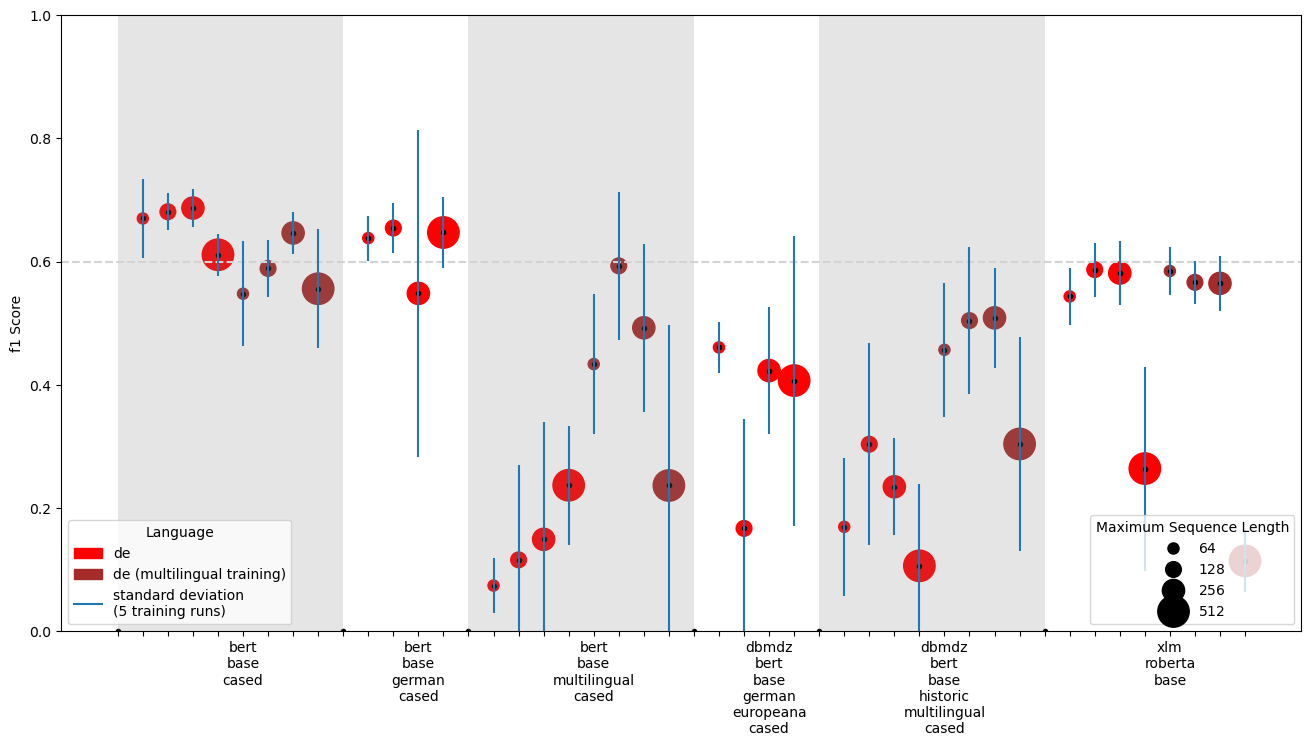

In [61]:
plot_results(grouped_ne_dev, ["de", "multilingual-de"], score="f1")

/tmp/ipykernel_1658430/1067915846.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(n_x, rotation=0, rotation_mode='anchor', ha="center") #rotation=75


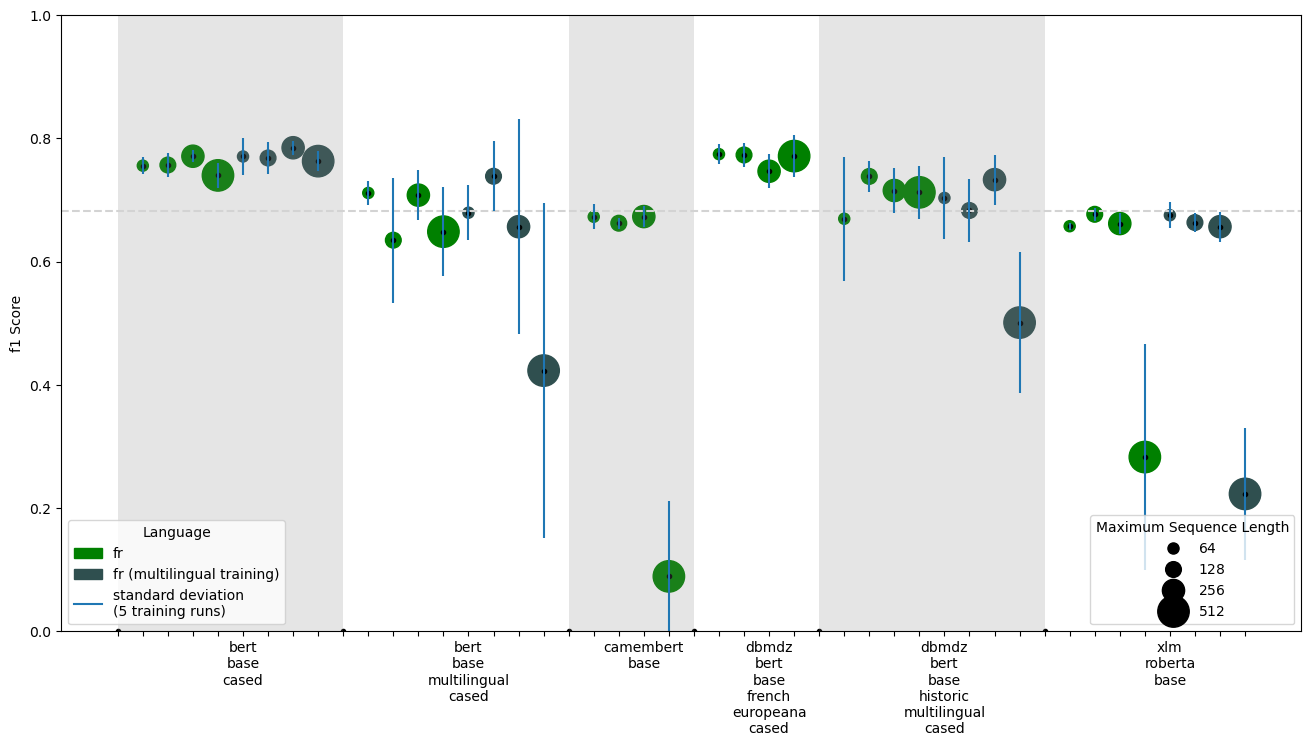

In [62]:
plot_results(grouped_ne_dev, ["fr", "multilingual-fr"], set="dev")

### Test set

In [63]:
ne_test = ne_global_metrics.loc[(ne_global_metrics["set"]=="test") &
                                    ne_global_metrics["run"].notna()]
grouped_ne_test = ne_test.groupby(["model", "language", "max_sequence_length"]).agg({"run": "count", 
                                                                                   "f1": [np.mean, np.std],
                                                                                   "precision": [np.mean, np.std],
                                                                                   "recall": [np.mean, np.std]}).reset_index()
grouped_ne_test

model         language max_sequence_length   run        f1  \
                                                          count      mean   
0    bert_base_cased               de                  64     5  0.811555   
1    bert_base_cased               de                 128     5  0.838364   
2    bert_base_cased               de                 256     5  0.827551   
3    bert_base_cased               de                 512     5  0.825385   
4    bert_base_cased               fr                  64     5  0.740434   
..               ...              ...                 ...   ...       ...   
75  xlm_roberta_base  multilingual-de                 512     5  0.101511   
76  xlm_roberta_base  multilingual-fr                  64     5  0.658288   
77  xlm_roberta_base  multilingual-fr                 128     5  0.654762   
78  xlm_roberta_base  multilingual-fr                 256     5  0.641703   
79  xlm_roberta_base  multilingual-fr                 512     5  0.176902   

             precision              recall            
         std      mean       std      mean       std  
0   0.035700  0.776582  0.047546  0.850980  0.035619  
1   0.027034  0.826921  0.045421  0.850980  0.010740  
2   0.046942  0.822991  0.074013  0.833962  0.020669  
3   0.022213  0.815642  0.047693  0.837037  0.015494  
4   0.024030  0.741543  0.033155  0.739726  0.019969  
..       ...       ...       ...       ...       ...  
75  0.084475  0.109819  0.090071  0.094545  0.079669  
76  0.019601  0.713169  0.041717  0.612081  0.014550  
77  0.022771  0.728699  0.030600  0.594805  0.023232  
78  0.022270  0.716828  0.020444  0.580892  0.023575  
79  0.095561  0.240902  0.086900  0.144654  0.084964  

[80 rows x 10 columns]

/tmp/ipykernel_1658430/1067915846.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(n_x, rotation=0, rotation_mode='anchor', ha="center") #rotation=75


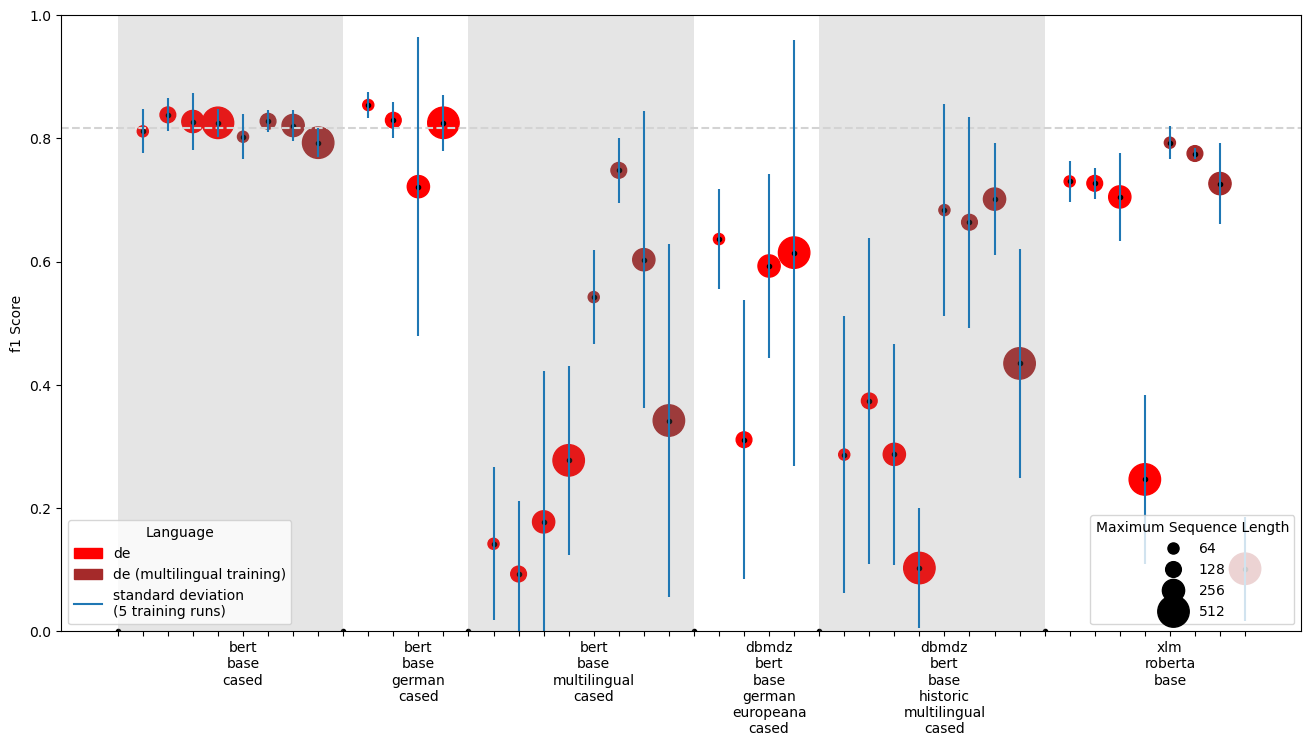

In [64]:
plot_results(grouped_ne_test, ["de", "multilingual-de"], set="test", score="f1")

/tmp/ipykernel_1658430/1067915846.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(n_x, rotation=0, rotation_mode='anchor', ha="center") #rotation=75


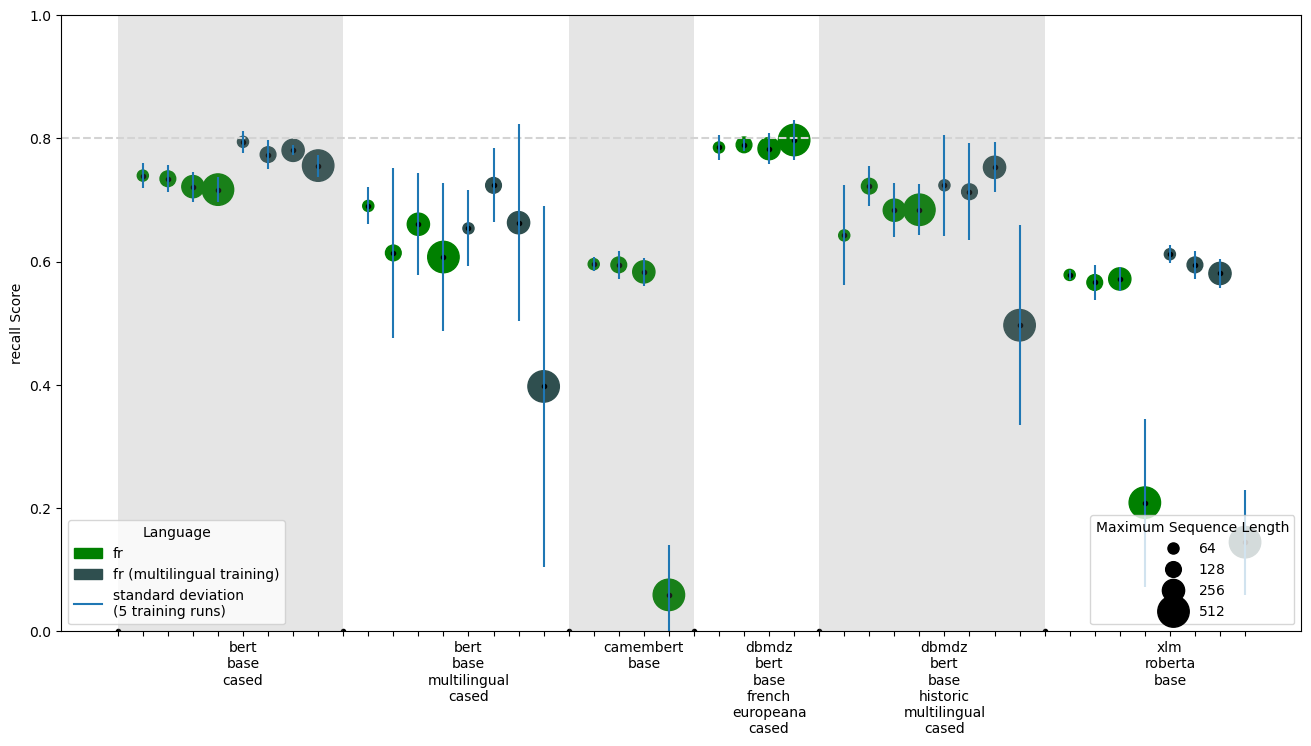

In [65]:
plot_results(grouped_ne_test, ["fr", "multilingual-fr"], set="test", score="recall")

## Sentence-Level Classification

In [66]:
METRICS_LABELS = ["0", "1", "macro_avg", "accuracy"]
sent_global_metrics = pd.DataFrame()

for model in sent_test_metrics:
    dev_metrics = sent_dev_metrics[model]
    test_metrics = sent_test_metrics[model]
    chosen_dev_metrics = dev_metrics[dev_metrics["label"].isin(METRICS_LABELS)] 
    chosen_dev_metrics.insert(0, "set", "dev")
    chosen_test_metrics = test_metrics[test_metrics["label"].isin(METRICS_LABELS)] 
    chosen_test_metrics.insert(0, "set", "test")

    #add model specifications at beginning of dataframe
    for i, items in enumerate(parse_model_name(model).items()):
        col, value = items
        chosen_dev_metrics.insert(i, col, value)
        chosen_test_metrics.insert(i, col, value)
    
    #save all in DataFrame
    sent_global_metrics = pd.concat([sent_global_metrics, chosen_dev_metrics, chosen_test_metrics])

#only get later experiments
sent_global_metrics = sent_global_metrics[sent_global_metrics["run"].notna()]
#for micro_avg, accuracy=precision=recall
sent_global_metrics = sent_global_metrics.replace("_", None).fillna(method="backfill", axis=1)

sent_global_metrics[["max_sequence_length", "epochs"]] = sent_global_metrics[["max_sequence_length", "epochs"]].astype(int)
sent_global_metrics[["precision", "recall", "f1"]] = sent_global_metrics[["precision", "recall", "f1"]].astype(float)

In [67]:
sent_dev = sent_global_metrics[(sent_global_metrics["set"] == "dev") &
                                (sent_global_metrics["label"].isin(["0", "1", "accuracy", "macro_avg"]))]
grouped_sent_dev = sent_dev.groupby(["model", "language", "max_sequence_length", "label"]).agg({"run": "count", "f1": [np.mean, np.std]}).reset_index()
grouped_sent_dev

model         language max_sequence_length      label   run  \
                                                                      count   
0     bert_base_cased               de                  64          0     5   
1     bert_base_cased               de                  64          1     5   
2     bert_base_cased               de                  64   accuracy     5   
3     bert_base_cased               de                  64  macro_avg     5   
4     bert_base_cased               de                 128          0     5   
..                ...              ...                 ...        ...   ...   
315  xlm_roberta_base  multilingual-fr                 256  macro_avg     5   
316  xlm_roberta_base  multilingual-fr                 512          0     5   
317  xlm_roberta_base  multilingual-fr                 512          1     5   
318  xlm_roberta_base  multilingual-fr                 512   accuracy     5   
319  xlm_roberta_base  multilingual-fr                 512  macro_avg     5   

          f1            
        mean       std  
0    0.73614  0.038275  
1    0.99392  0.001112  
2    0.98814  0.002192  
3    0.86504  0.019706  
4    0.77220  0.020571  
..       ...       ...  
315  0.91368  0.004824  
316  0.75684  0.028991  
317  0.99120  0.000857  
318  0.98300  0.001617  
319  0.87400  0.014857  

[320 rows x 7 columns]

/tmp/ipykernel_1658430/1067915846.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(n_x, rotation=0, rotation_mode='anchor', ha="center") #rotation=75


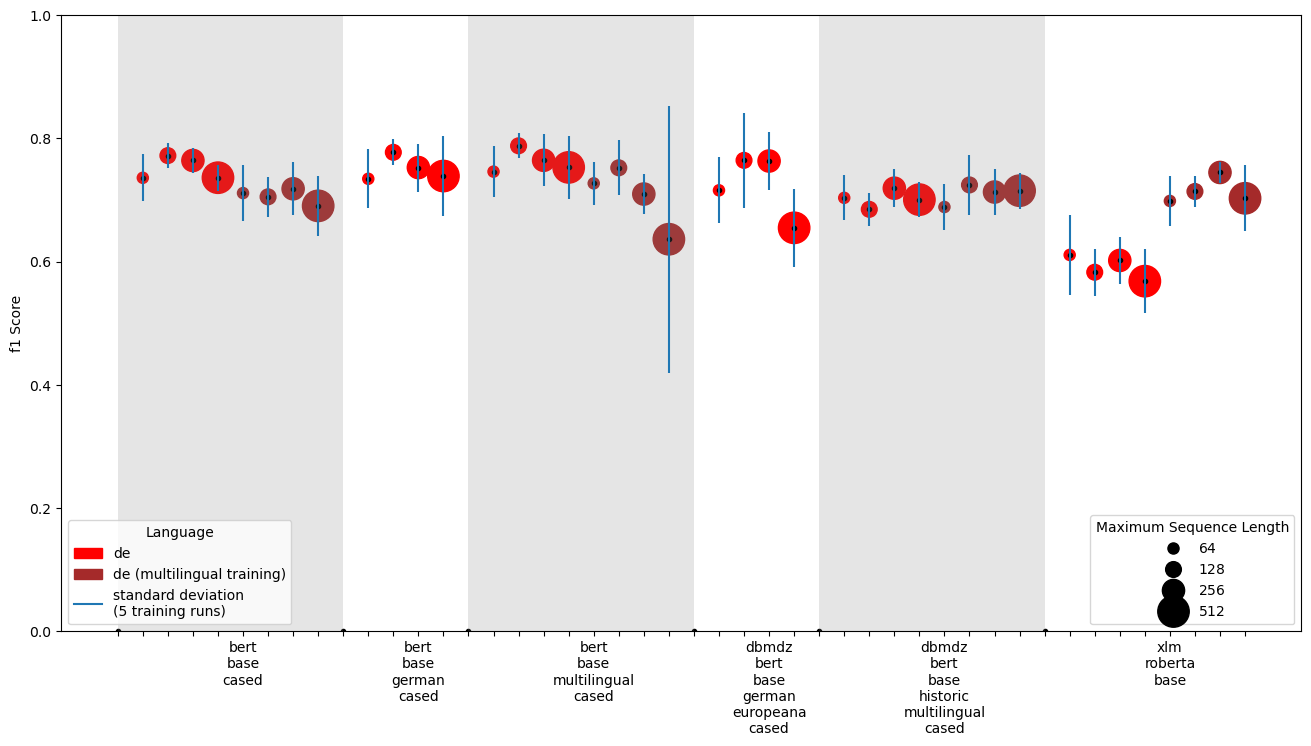

In [68]:
plot_results(grouped_sent_dev[grouped_sent_dev["label"]=="0"], ["de", "multilingual-de"], add_baseline=False)

/tmp/ipykernel_1658430/1067915846.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(n_x, rotation=0, rotation_mode='anchor', ha="center") #rotation=75


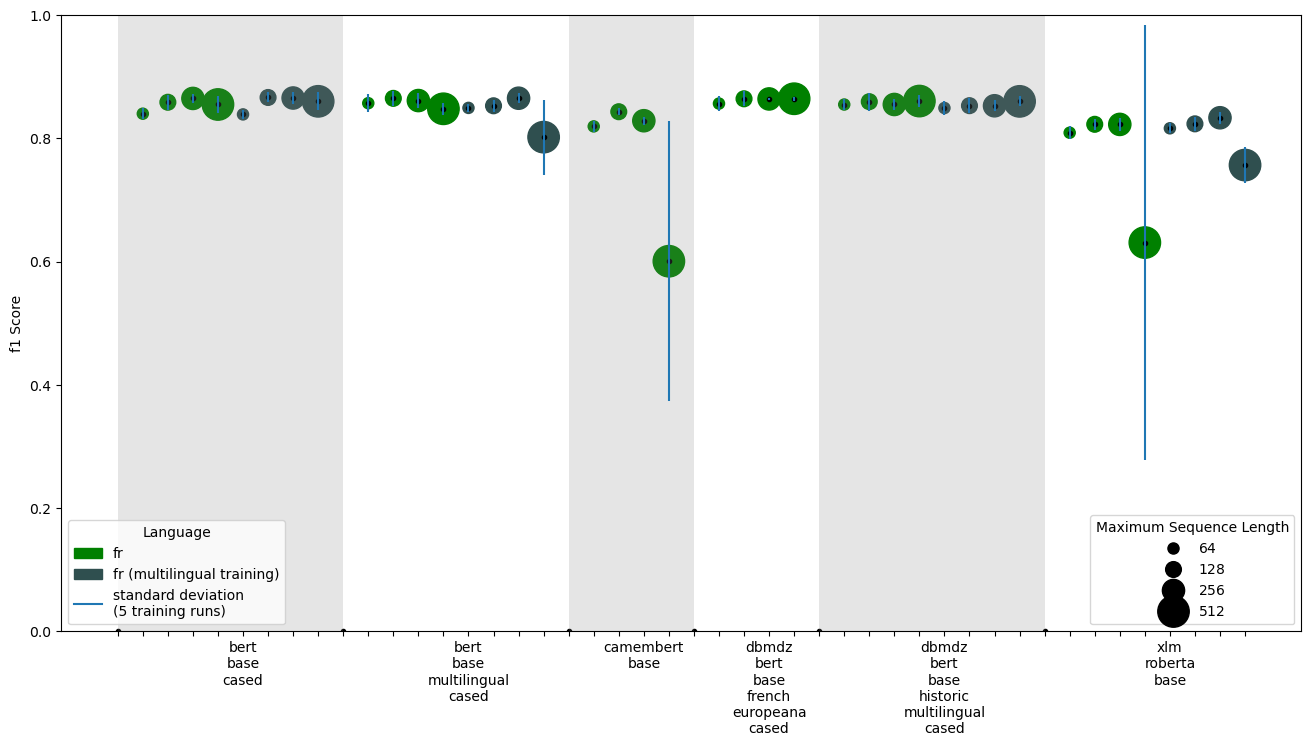

In [69]:
plot_results(grouped_sent_dev[grouped_sent_dev["label"]=="0"], ["fr", "multilingual-fr"], add_baseline=False)

In [70]:
sent_test = sent_global_metrics[(sent_global_metrics["set"] == "test") &
                                (sent_global_metrics["label"].isin(["0", "1", "accuracy", "macro_avg"]))]
grouped_sent_test = sent_test.groupby(["model", "language", "max_sequence_length", "label"]).agg({"run": "count", "f1": [np.mean, np.std]}).reset_index()
grouped_sent_test

model         language max_sequence_length      label   run  \
                                                                      count   
0     bert_base_cased               de                  64          0     5   
1     bert_base_cased               de                  64          1     5   
2     bert_base_cased               de                  64   accuracy     5   
3     bert_base_cased               de                  64  macro_avg     5   
4     bert_base_cased               de                 128          0     5   
..                ...              ...                 ...        ...   ...   
315  xlm_roberta_base  multilingual-fr                 256  macro_avg     5   
316  xlm_roberta_base  multilingual-fr                 512          0     5   
317  xlm_roberta_base  multilingual-fr                 512          1     5   
318  xlm_roberta_base  multilingual-fr                 512   accuracy     5   
319  xlm_roberta_base  multilingual-fr                 512  macro_avg     5   

          f1            
        mean       std  
0    0.85224  0.010463  
1    0.99250  0.000570  
2    0.98570  0.001075  
3    0.92236  0.005513  
4    0.84246  0.020366  
..       ...       ...  
315  0.90060  0.004474  
316  0.74362  0.033487  
317  0.98770  0.001528  
318  0.97652  0.002951  
319  0.86566  0.017496  

[320 rows x 7 columns]

# HIPE Scorer

In [71]:
def import_HIPE_results(times=["TIME-ALL"], noise_levels=["LED-ALL"], set="dev", metrics=["F1_micro", "F1_macro_doc"], suffix="_time_noise"):
    df = pd.DataFrame()

    for model in os.listdir(MODEL_OUTPUT):
        model_path = os.path.join(MODEL_OUTPUT, model)
        #exclude files and early experiments
        if not os.path.isdir(model_path):
            continue
        if not "run" in model:
            continue
        
        json_files = [ x for x in os.listdir(os.path.join(MODEL_OUTPUT, model)) if f"pred_nerc_fine{suffix}.json" in x ]
        #continue if no nerc_fine predictions in experiments folder
        if not json_files:
            continue
        try:
            json_test_files = [x for x in json_files if set in x]
        except:
            print(f"No {set} file in {model}, but:", json_files)
            continue

        #save stats for every dev/test file (1 for de/fr, 2 for multilingual)       
        for json_test_file in json_test_files:    
            #get the data    
            with open(os.path.join(model_path, json_test_file), "r") as f:
                model_res = json.load(f)

            #collect the results
            res_dict = {"time": [], "noise_level": []}
            res_dict.update({metric: [] for metric in metrics})

            
            for time in times:
                for noise_level in noise_levels:
                    res_dict["time"].append(time)
                    res_dict["noise_level"].append(noise_level)
                    for metric in metrics:
                        try:
                            res_dict[metric].append(model_res["NE-FINE-LIT"][time][noise_level]["ALL"]["ent_type"][metric])
                        except:
                            print("Could not retrive results for model:", model)
                            if len(model_res["NE-FINE-LIT"].keys()) >1:
                                print("Keys present:", model_res["NE-FINE-LIT"].keys())
                            continue
            
            
            #parse modelname
            modelname = model
            #if trained multilingual, but evaluated separately for fr and de, need to store language information 
            if "run_multilingual" in modelname:
                try:
                    lang = re.findall(r"-([a-z]+)_pred_nerc_fine", json_test_file)[0]
                except:
                    print("Was not able to infer language from files in:" , modelname)
                modelname = modelname.replace("run_multilingual", f"run_multilingual-{lang}")
            
            modelname_df = pd.DataFrame(parse_model_name(modelname), index=[0])  
            modelname_df = pd.concat([modelname_df]*len(times)*len(noise_levels), ignore_index=True)
            
            #concat modelname and results and add dataframe to overall df
            try:
                cur_df = pd.concat([modelname_df, pd.DataFrame(res_dict)], axis=1)
                df = pd.concat([df, cur_df], ignore_index=True)
            except:
                #print("NO RESULTS", model)
                pass
    df["max_sequence_length"] = df["max_sequence_length"].astype(int)
    df["epochs"] = df["epochs"].astype(int)
    df = df.sort_values(by=["model", "max_sequence_length", "suffix"])

    return df


In [72]:
ne_HIPE = import_HIPE_results(suffix="", set="dev")
grouped_ne_HIPE = ne_HIPE.groupby(["model", "language", "max_sequence_length"]).agg(
    {"run": "count", 
     "F1_micro": [np.mean, np.std],
     "F1_macro_doc": [np.mean, np.std]}
     ).reset_index()

grouped_ne_HIPE

model         language max_sequence_length   run  F1_micro  \
                                                          count      mean   
0    bert_base_cased               de                  64     5  0.702051   
1    bert_base_cased               de                 128     5  0.724086   
2    bert_base_cased               de                 256     5  0.714671   
3    bert_base_cased               de                 512     5  0.672509   
4    bert_base_cased               fr                  64     5  0.756891   
..               ...              ...                 ...   ...       ...   
75  xlm_roberta_base  multilingual-de                 512     5  0.150176   
76  xlm_roberta_base  multilingual-fr                  64     5  0.738561   
77  xlm_roberta_base  multilingual-fr                 128     5  0.761806   
78  xlm_roberta_base  multilingual-fr                 256     5  0.755672   
79  xlm_roberta_base  multilingual-fr                 512     5  0.282964   

             F1_macro_doc            
         std         mean       std  
0   0.063153     0.921926  0.049557  
1   0.022165     0.918148  0.016514  
2   0.045804     0.916148  0.060111  
3   0.051634     0.917630  0.041730  
4   0.025975     0.903939  0.016608  
..       ...          ...       ...  
75  0.065524     0.156611  0.098158  
76  0.025862     0.896882  0.018379  
77  0.018232     0.901731  0.021996  
78  0.027250     0.902163  0.028066  
79  0.133676     0.488333  0.194658  

[80 rows x 8 columns]

/tmp/ipykernel_1658430/1067915846.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(n_x, rotation=0, rotation_mode='anchor', ha="center") #rotation=75


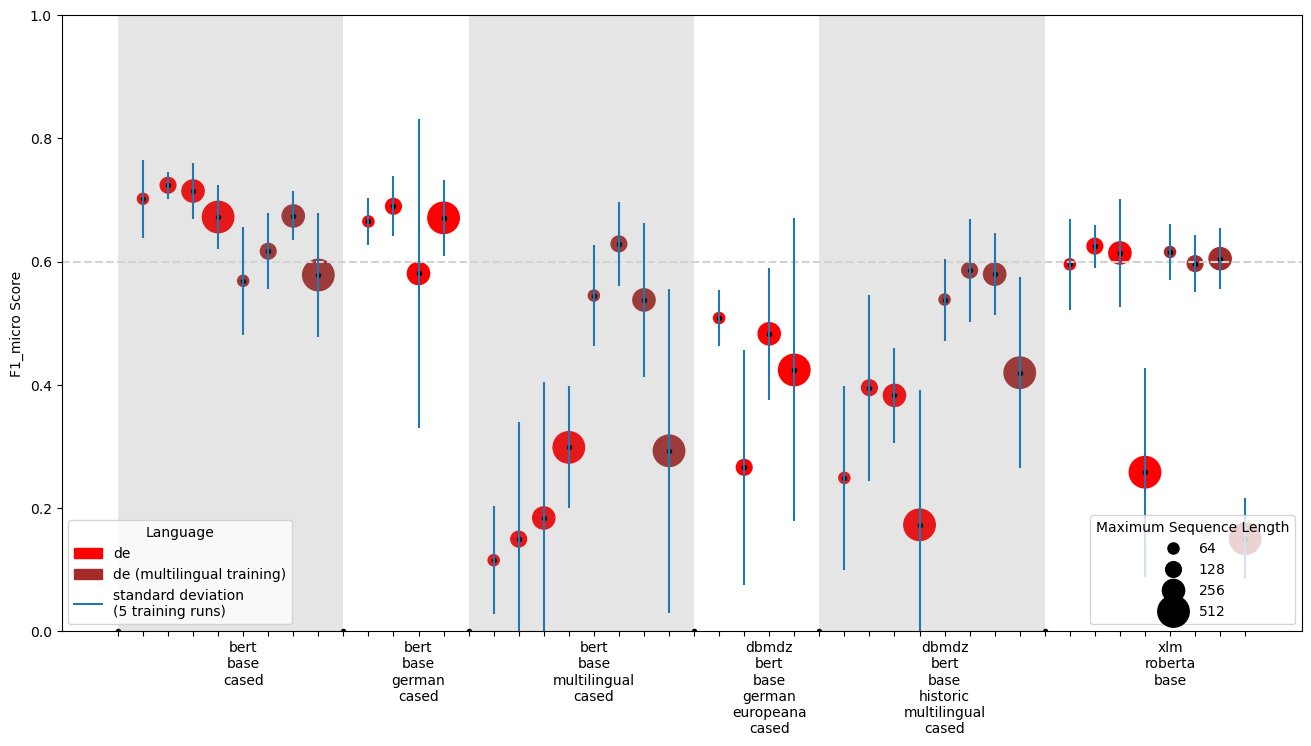

In [73]:
plot_results(grouped_ne_HIPE, languages=["de", "multilingual-de"], score="F1_micro")

/tmp/ipykernel_1658430/1067915846.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(n_x, rotation=0, rotation_mode='anchor', ha="center") #rotation=75


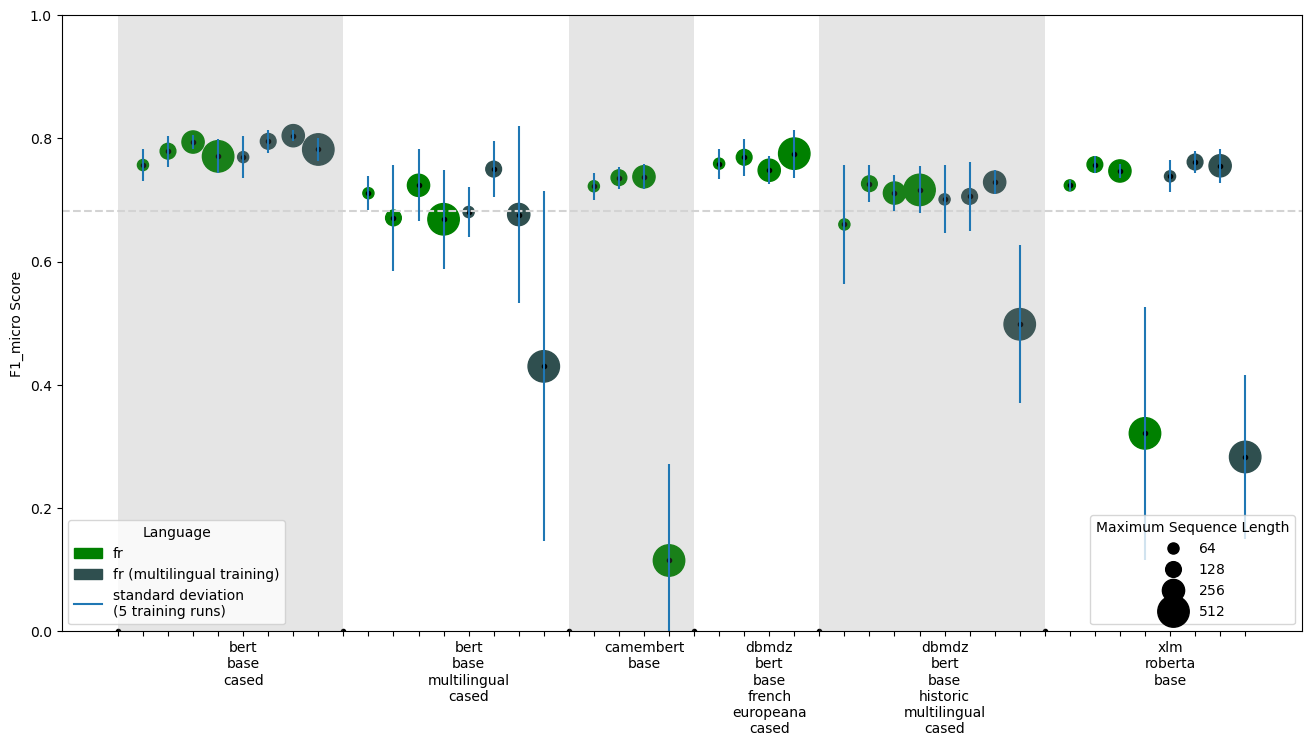

In [74]:
plot_results(grouped_ne_HIPE, languages=["fr", "multilingual-fr"], score="F1_micro")

## Noise and Time levels

In [75]:
NOISE_LEVELS = ["LED-0.0-0.0", "LED-0.001-0.1", "LED-0.1-0.3", "LED-0.3-1.1"]
TIME_LEVELS = ["TIME-1800-1900", "TIME-1900-1940", "TIME-1940-2000"]

In [76]:
def stem_plot_results(orig_df, title, languages=["de"], split_by="time", levels=TIME_LEVELS, metric="F1_micro", 
                      reverse_levels=False):
    """  
    Stem Plot to plot results split by noise and time levels.
    """
    #only keep rows which have at least one annotation
    df_copy = orig_df.copy()
    df_copy["counts"] = df_copy["TP"]["sum"] + df_copy["FN"]["sum"]
    not_na = df_copy[df_copy["counts"] > 0]

    lang_df = not_na[not_na["language"].isin(languages)]

    # define general marker forms and colors
    markers = dict(zip(list(range(4)), ["o", "D", "p", "*"]))
    colors = dict(zip(list(range(4)), ["b", "g", "c", "m"]))

    # instantiate plot
    fig, ax = plt.subplots(figsize=(12,8))

    # plotting aesthetics
    if reverse_levels:
        levels = reversed(levels)
        
    # for each split, plot a stem plot, all on top of each other, with different markers
    for i, split in enumerate(levels):
        df = lang_df[lang_df[split_by]==split]
        if df.empty:
            continue
        y = df["model"].str.cat(df[["language", "max_sequence_length"]].values.astype(str),sep='-|-')
        x = df[metric]["mean"]

        ax.stem(y, x, orientation="horizontal", basefmt="grey", markerfmt=markers[i], linefmt=colors[i], 
                label=f"{split} ({df['counts'].values[0]} agency mentions)")

    # legend
    ax.legend()#loc="right")#bbox_to_anchor=(1.1, 1.05))
    ax.set_xlabel(metric)
    ax.set_title(title)
    
    plt.show()

In [77]:
time_dev_HIPE = import_HIPE_results(times=TIME_LEVELS, suffix="_time_noise", metrics=["F1_micro", "F1_macro_doc", "TP", "FN"])
grouped_time_dev_HIPE = time_dev_HIPE.groupby(["model", "language", "max_sequence_length", "time"]).agg(
    {"run": "count", 
     "F1_micro": [np.mean, np.std],
     "F1_macro_doc": [np.mean, np.std],
     "TP": "sum", "FN": "sum"}
     ).reset_index()
grouped_time_dev_HIPE

model         language max_sequence_length            time  \
                                                                             
0     bert_base_cased               de                  64  TIME-1800-1900   
1     bert_base_cased               de                  64  TIME-1900-1940   
2     bert_base_cased               de                  64  TIME-1940-2000   
3     bert_base_cased               de                 128  TIME-1800-1900   
4     bert_base_cased               de                 128  TIME-1900-1940   
..                ...              ...                 ...             ...   
235  xlm_roberta_base  multilingual-fr                 256  TIME-1900-1940   
236  xlm_roberta_base  multilingual-fr                 256  TIME-1940-2000   
237  xlm_roberta_base  multilingual-fr                 512  TIME-1800-1900   
238  xlm_roberta_base  multilingual-fr                 512  TIME-1900-1940   
239  xlm_roberta_base  multilingual-fr                 512  TIME-1940-2000   

      run  F1_micro           F1_macro_doc             TP   FN  
    count      mean       std         mean       std  sum  sum  
0       5  0.000000  0.000000          NaN       NaN    0    5  
1       5  0.444001  0.129043     0.844444  0.126686   18   12  
2       5  0.916667  0.000000     0.966667  0.000000   55   10  
3       5  0.000000  0.000000          NaN       NaN    0    5  
4       5  0.501438  0.058529     0.852778  0.049690   21    9  
..    ...       ...       ...          ...       ...  ...  ...  
235     5  0.810712  0.024946     0.919734  0.015213  107   28  
236     5  0.746393  0.045831     0.879982  0.035537  173   72  
237     5  0.228263  0.231686     0.479167  0.410369   11   39  
238     5  0.410154  0.296334     0.586756  0.267183   55   80  
239     5  0.209752  0.112051     0.394099  0.220045   46  199  

[240 rows x 11 columns]

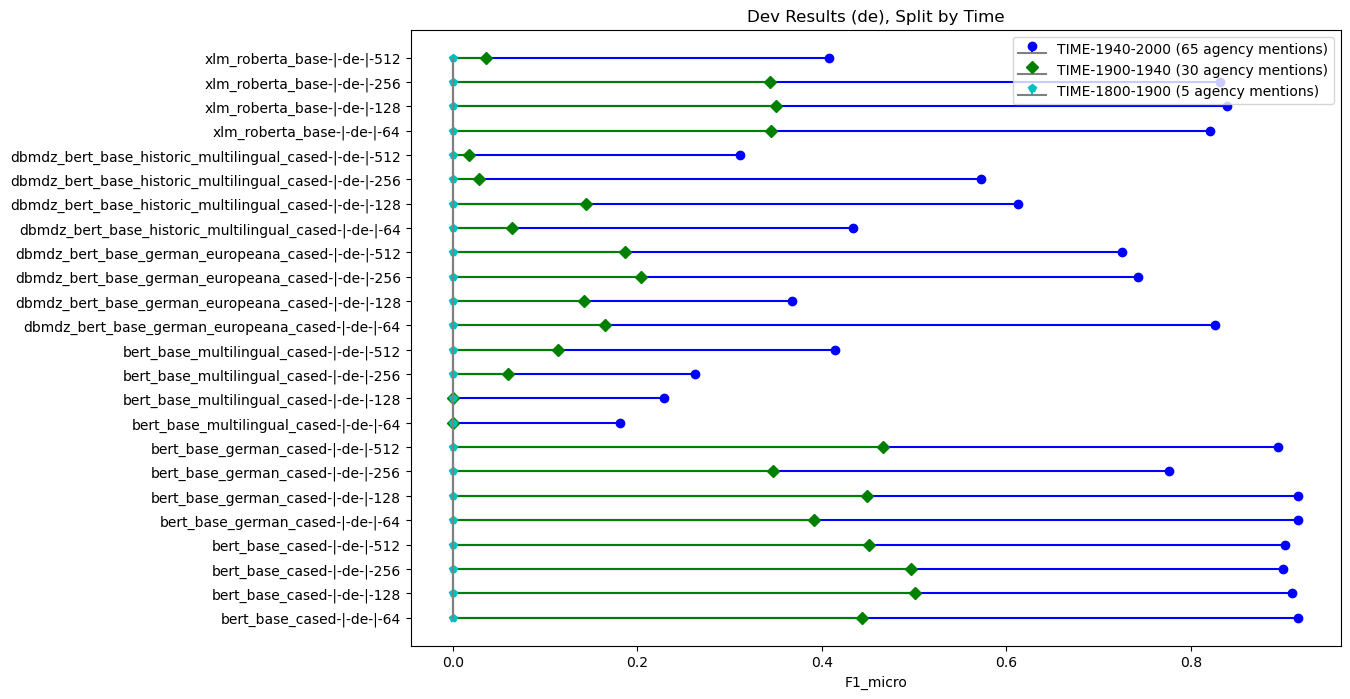

In [78]:
stem_plot_results(grouped_time_dev_HIPE, title="Dev Results (de), Split by Time", reverse_levels=True)

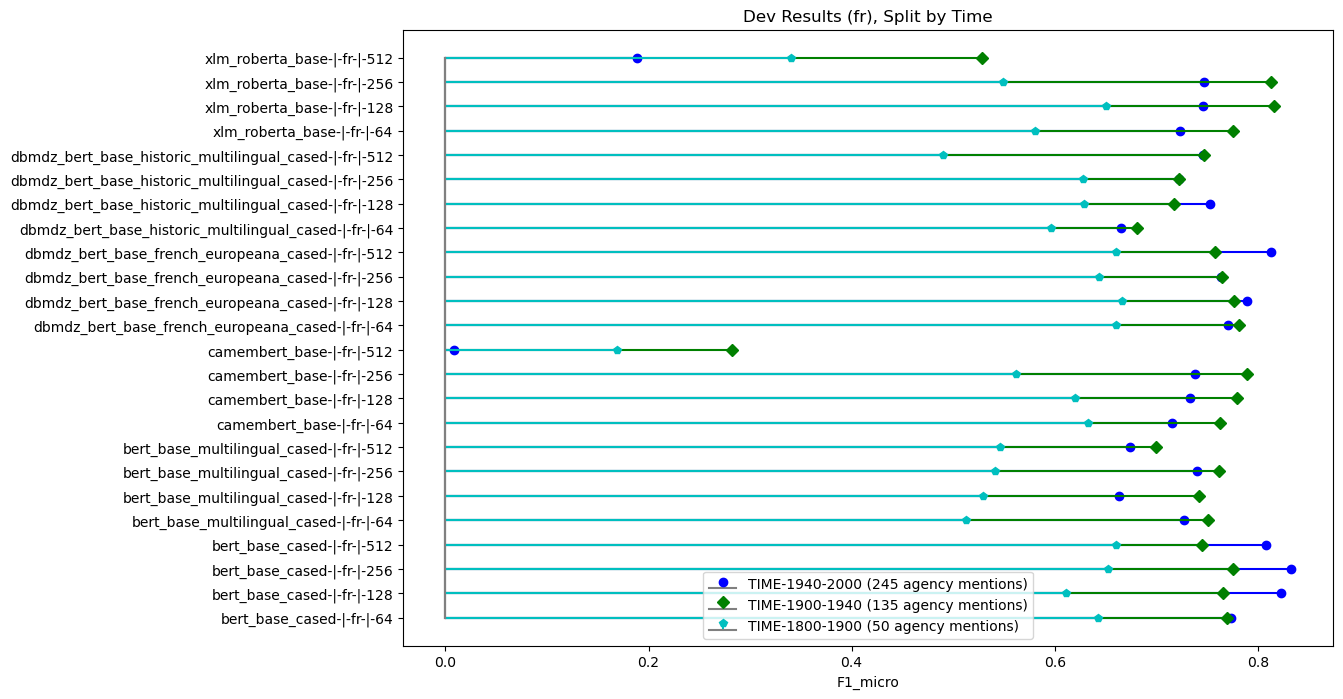

In [79]:
stem_plot_results(grouped_time_dev_HIPE, title="Dev Results (fr), Split by Time", languages=["fr"], reverse_levels=True)

In [80]:
noise_dev_HIPE = import_HIPE_results(noise_levels=NOISE_LEVELS, suffix="_time_noise", metrics=["F1_micro", "F1_macro_doc", "TP", "FN"])
grouped_noise_dev_HIPE = noise_dev_HIPE.groupby(["model", "language", "max_sequence_length", "noise_level"]).agg(
    {"run": "count", 
     "F1_micro": [np.mean, np.std],
     "F1_macro_doc": [np.mean, np.std],
     "TP": "sum", "FN": "sum"}
     ).reset_index()
grouped_noise_dev_HIPE

model         language max_sequence_length    noise_level  \
                                                                            
0     bert_base_cased               de                  64    LED-0.0-0.0   
1     bert_base_cased               de                  64  LED-0.001-0.1   
2     bert_base_cased               de                  64    LED-0.1-0.3   
3     bert_base_cased               de                  64    LED-0.3-1.1   
4     bert_base_cased               de                 128    LED-0.0-0.0   
..                ...              ...                 ...            ...   
315  xlm_roberta_base  multilingual-fr                 256    LED-0.3-1.1   
316  xlm_roberta_base  multilingual-fr                 512    LED-0.0-0.0   
317  xlm_roberta_base  multilingual-fr                 512  LED-0.001-0.1   
318  xlm_roberta_base  multilingual-fr                 512    LED-0.1-0.3   
319  xlm_roberta_base  multilingual-fr                 512    LED-0.3-1.1   

      run  F1_micro           F1_macro_doc             TP   FN  
    count      mean       std         mean       std  sum  sum  
0       5  0.715568  0.067859     0.928593  0.037733   70   20  
1       5  0.000000  0.000000          NaN       NaN    0    0  
2       5  0.000000  0.000000          NaN       NaN    0    5  
3       5  0.177778  0.205631     1.000000  0.000000    3    2  
4       5  0.747895  0.031765     0.934074  0.019059   74   16  
..    ...       ...       ...          ...       ...  ...  ...  
315     5  0.000000  0.000000          NaN       NaN    0    0  
316     5  0.284417  0.132501     0.485450  0.192820  109  301  
317     5  0.063386  0.062861     0.625000  0.478714    3    2  
318     5  0.000000  0.000000     0.000000  0.000000    0   15  
319     5  0.000000  0.000000          NaN       NaN    0    0  

[320 rows x 11 columns]

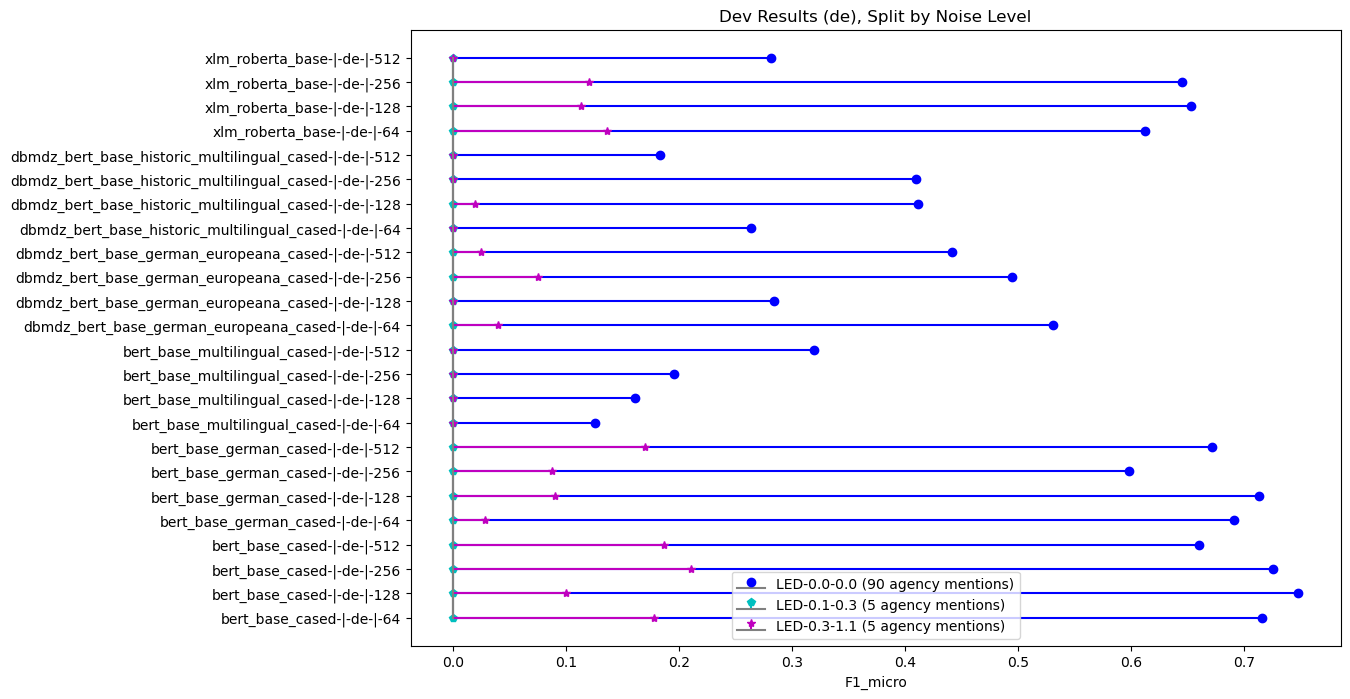

In [81]:
stem_plot_results(grouped_noise_dev_HIPE, title="Dev Results (de), Split by Noise Level", split_by="noise_level", 
                  levels=NOISE_LEVELS)

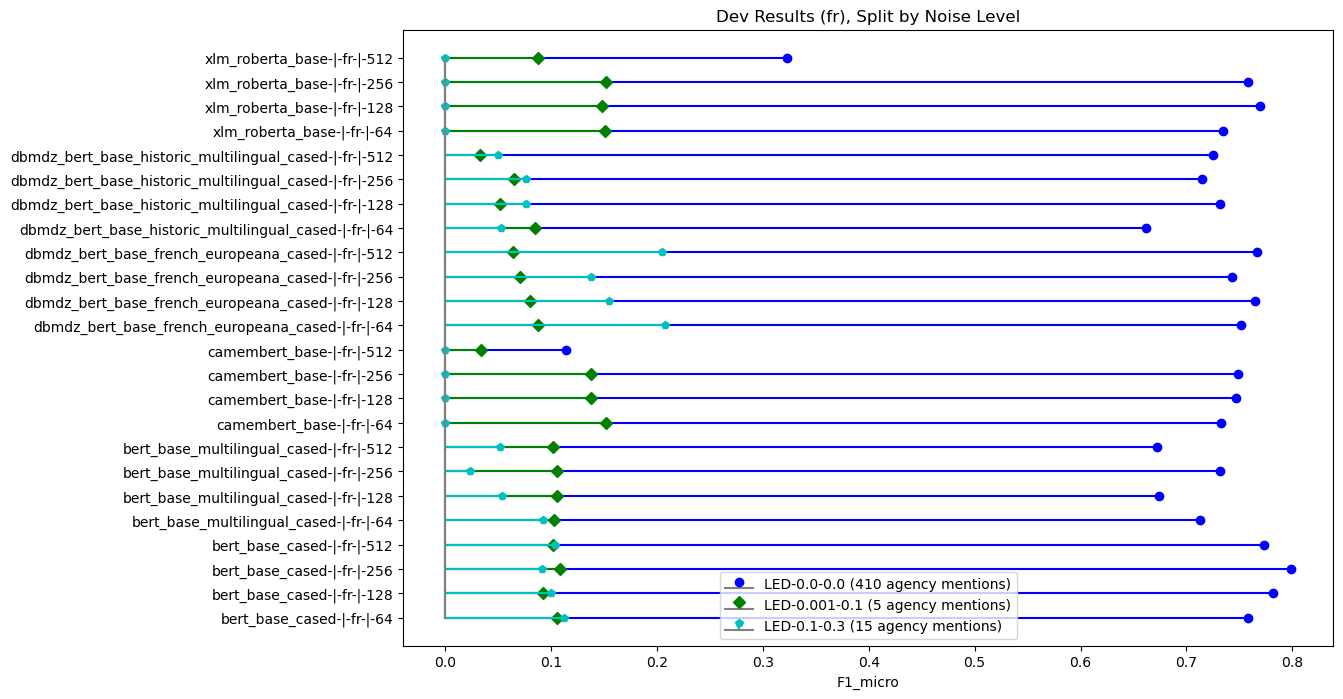

In [82]:
stem_plot_results(grouped_noise_dev_HIPE, title="Dev Results (fr), Split by Noise Level", languages=["fr"], split_by="noise_level", 
                  levels=NOISE_LEVELS)

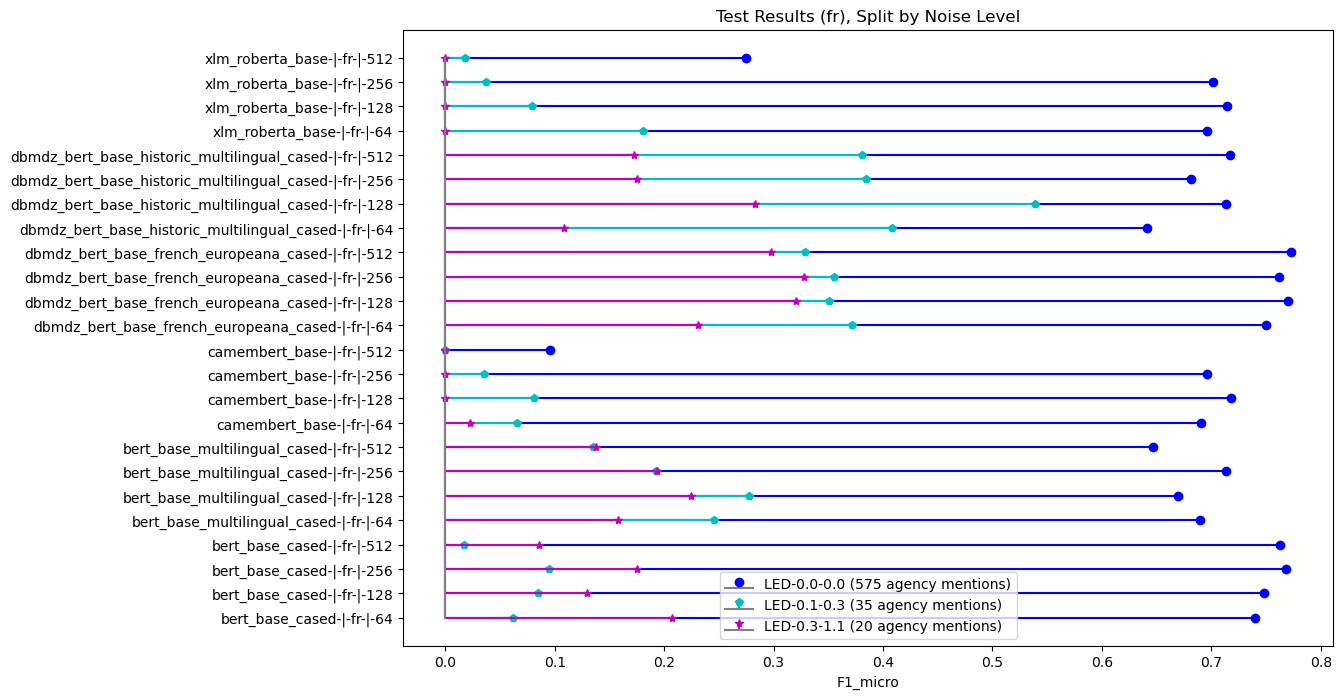

In [83]:
noise_test_HIPE = import_HIPE_results(noise_levels=NOISE_LEVELS, suffix="_time_noise", set="test", metrics=["F1_micro", "F1_macro_doc", "TP", "FN"])
grouped_noise_test_HIPE = noise_test_HIPE.groupby(["model", "language", "max_sequence_length", "noise_level"]).agg(
    {"run": "count", 
     "F1_micro": [np.mean, np.std],
     "F1_macro_doc": [np.mean, np.std],
     "TP": "sum", "FN": "sum"}
     ).reset_index()
stem_plot_results(grouped_noise_test_HIPE, title="Test Results (fr), Split by Noise Level", languages=["fr"], split_by="noise_level", 
                  levels=NOISE_LEVELS)

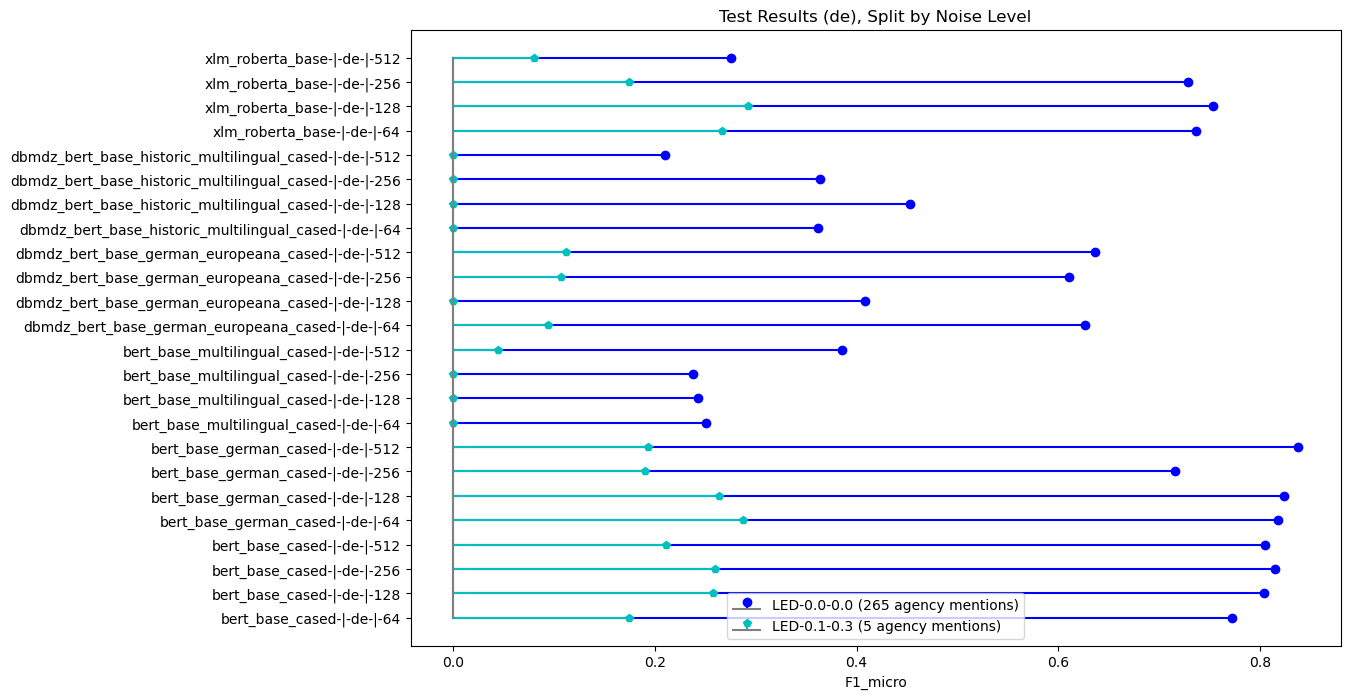

In [84]:
stem_plot_results(grouped_noise_test_HIPE, title="Test Results (de), Split by Noise Level", languages=["de"], split_by="noise_level", 
                  levels=NOISE_LEVELS)

## Save evaluation data

### Metrics to pickle

In [85]:
ne_global_metrics.to_pickle(os.path.join(MODEL_OUTPUT, "NE_metrics.pkl"))
sent_global_metrics.to_pickle(os.path.join(MODEL_OUTPUT, "Sent_metrics.pkl"))

In [86]:
with open(os.path.join(MODEL_OUTPUT, 'NE_all_test_metrics.pkl'), 'wb') as f:
    pickle.dump(ne_test_metrics, f)

with open(os.path.join(MODEL_OUTPUT, 'Sent_all_test_metrics.pkl'), 'wb') as f:
    pickle.dump(sent_test_metrics, f)

### Metrics to csv

In [87]:
for name, stats in {"grouped_ne_dev": grouped_ne_dev, "grouped_ne_test": grouped_ne_test,
                    "grouped_sent_dev": grouped_sent_dev, "grouped_sent_test": grouped_sent_test}.items():
    df = grouped_ne_dev.copy()
    #get rid of multiindex
    df.columns = df.columns.map('_'.join)
    #round float numbers to 3 decimal places
    col_select = [col for col in df.columns if ("mean" in col) or ("std" in col)]
    df[col_select] = df[col_select].round(3)
    
    # save results
    print(f"save df to {os.path.join(MODEL_OUTPUT, f'{name}.csv')}")
    df.to_csv(os.path.join(MODEL_OUTPUT, f'{name}.csv'))

save df to experiments/grouped_ne_dev.csv
save df to experiments/grouped_ne_test.csv
save df to experiments/grouped_sent_dev.csv
save df to experiments/grouped_sent_test.csv


In [88]:
df.head()

,model_,language_,max_sequence_length_,run_count,f1_mean,f1_std,precision_mean,precision_std,recall_mean,recall_std
0,bert_base_cased,de,64,5,0.670,0.065,0.668,0.113,0.678,0.024
1,bert_base_cased,de,128,5,0.681,0.030,0.668,0.040,0.696,0.031
2,bert_base_cased,de,256,5,0.687,0.031,0.674,0.056,0.704,0.036
3,bert_base_cased,de,512,5,0.611,0.034,0.560,0.065,0.678,0.024
4,bert_base_cased,fr,64,5,0.756,0.014,0.684,0.015,0.845,0.016


### combine all result files in one zip folder

In [89]:
RESULTS_DIR = "results"

#get all models
models = [doc for doc in os.listdir(MODEL_OUTPUT) 
          if os.path.isdir(os.path.join(MODEL_OUTPUT,doc))]


for model in models: 
    #get all results of form "all_results_{de, fr}.json" and "newsagency-data..._pred.tsv"
    results_to_save = [doc for doc in os.listdir(os.path.join(MODEL_OUTPUT, model)) if ("all_results" in doc) or ("pred" in doc) or (".tsv" in doc)]
    if results_to_save:
        #copy files to new directory
        os.makedirs(os.path.join(RESULTS_DIR, model), exist_ok=True)
        for result in results_to_save:
            shutil.copyfile(os.path.join(MODEL_OUTPUT, model, result), os.path.join(RESULTS_DIR, model, result))
        print(f"Saved {results_to_save} in folder {os.path.join(RESULTS_DIR, model)}")

#make a zipfile out of results directory
print(f"Make zipfile of {RESULTS_DIR}")
shutil.make_archive("results", 'zip', RESULTS_DIR)
print(f"Done")

Saved ['newsagency-data-2-test-de_pred_nerc_fine.json', 'newsagency-data-2-test-de_pred_nerc_fine.tsv', 'newsagency-data-2-dev-de_pred_nerc_fine.tsv', 'newsagency-data-2-dev-de_pred.tsv', 'newsagency-data-2-dev-de_pred_nerc_fine.json', 'newsagency-data-2-dev-de_pred_nerc_fine_time_noise.tsv', 'all_results_de.json', 'newsagency-data-2-test-de_pred.tsv', 'newsagency-data-2-dev-de_pred_nerc_fine_time_noise.json', 'newsagency-data-2-test-de_pred_nerc_fine_time_noise.tsv', 'newsagency-data-2-test-de_pred_nerc_fine_time_noise.json'] in folder results/model_bert_base_german_cased_max_sequence_length_128_epochs_3_run_de_2
Saved ['newsagency-data-2-test-de_pred_nerc_fine.json', 'newsagency-data-2-test-de_pred_nerc_fine.tsv', 'newsagency-data-2-dev-de_pred_nerc_fine.tsv', 'newsagency-data-2-dev-de_pred.tsv', 'newsagency-data-2-dev-de_pred_nerc_fine.json', 'newsagency-data-2-dev-de_pred_nerc_fine_time_noise.tsv', 'all_results_de.json', 'newsagency-data-2-test-de_pred.tsv', 'newsagency-data-2-dev-

Saved ['newsagency-data-2-dev-fr_pred_nerc_fine.json', 'newsagency-data-2-test-fr_pred_nerc_fine_time_noise.tsv', 'newsagency-data-2-test-de_pred_nerc_fine.json', 'newsagency-data-2-test-de_pred_nerc_fine.tsv', 'newsagency-data-2-test-fr_pred.tsv', 'newsagency-data-2-dev-fr_pred.tsv', 'newsagency-data-2-dev-de_pred_nerc_fine.tsv', 'newsagency-data-2-test-fr_pred_nerc_fine.json', 'newsagency-data-2-dev-de_pred.tsv', 'newsagency-data-2-dev-fr_pred_nerc_fine_time_noise.json', 'newsagency-data-2-dev-fr_pred_nerc_fine_time_noise.tsv', 'newsagency-data-2-test-fr_pred_nerc_fine.tsv', 'newsagency-data-2-dev-de_pred_nerc_fine.json', 'newsagency-data-2-dev-de_pred_nerc_fine_time_noise.tsv', 'all_results_de.json', 'newsagency-data-2-test-de_pred.tsv', 'newsagency-data-2-test-fr_pred_nerc_fine_time_noise.json', 'all_results_fr.json', 'newsagency-data-2-dev-de_pred_nerc_fine_time_noise.json', 'newsagency-data-2-test-de_pred_nerc_fine_time_noise.tsv', 'newsagency-data-2-dev-fr_pred_nerc_fine.tsv', '